In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
from skimage import io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models

use_GPU = models.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

TORCH CUDA version not installed/working.
>>> GPU activated? 0


In [2]:
def enlarge_fused_image(fused, subimage_width=512, subimage_height=512, overlap=200):
    
    '''
    This function makes the fused image larger s.t. an integer number of
    subimages fits into it.
    
    INPUTS
    ------
        fused (np array)
        Fused (whole well) image.
        
        overlap (int)
        Overlap of subimages in pixels. Default is 100.
        
        subimage_width, subimage_height
        Size of subimages. Default is 512.
        
    OUTPUTS
    -------
        new_fused (np array)
        Enlarged fused image.
        
        subimage_locations (list with 2 elements)
        subimage_locations[0] is a numpy array with the x-coordinates of the subimages in pixels.
        subimage_locations[0] is a numpy array with the y-coordinates of the subimages in pixels.
    '''
    
    [H,W,C] = np.shape(fused)
    
    nx = np.ceil((W - subimage_width) / (subimage_width - overlap) + 1).astype(int)
    ny = np.ceil((H - subimage_height) / (subimage_height - overlap) + 1).astype(int)

    new_W = (nx - 1) * (subimage_width - overlap) + subimage_width
    new_H = (ny - 1) * (subimage_height - overlap) + subimage_height

    new_fused = np.zeros([new_H,new_W,C], dtype='uint8')
    new_fused[0:H,0:W,:] = fused
    
    subimage_locations = []
    subimage_locations.append(np.arange(0,new_W-subimage_width+1,subimage_width-overlap))   # x-locations
    subimage_locations.append(np.arange(0,new_H-subimage_height+1,subimage_height-overlap)) # y-locations

    return [new_fused, subimage_locations]

def fused_to_subimages(fused, subimage_locations):
    '''
    This function takes as input an (enlarged) fused image.
    It outputs a list of subimages which are ordered in a column-to-column grid.
    The locations of the subimgages in the fused image are specified by subimage_locations.
    '''
    subfig_list = []
    for x in subimage_locations[0]:
        for y in subimage_locations[1]:
            subfig = fused[y:y+subimage_height,x:x+subimage_width,:]
            subfig_list.append(subfig)
    
    return subfig_list

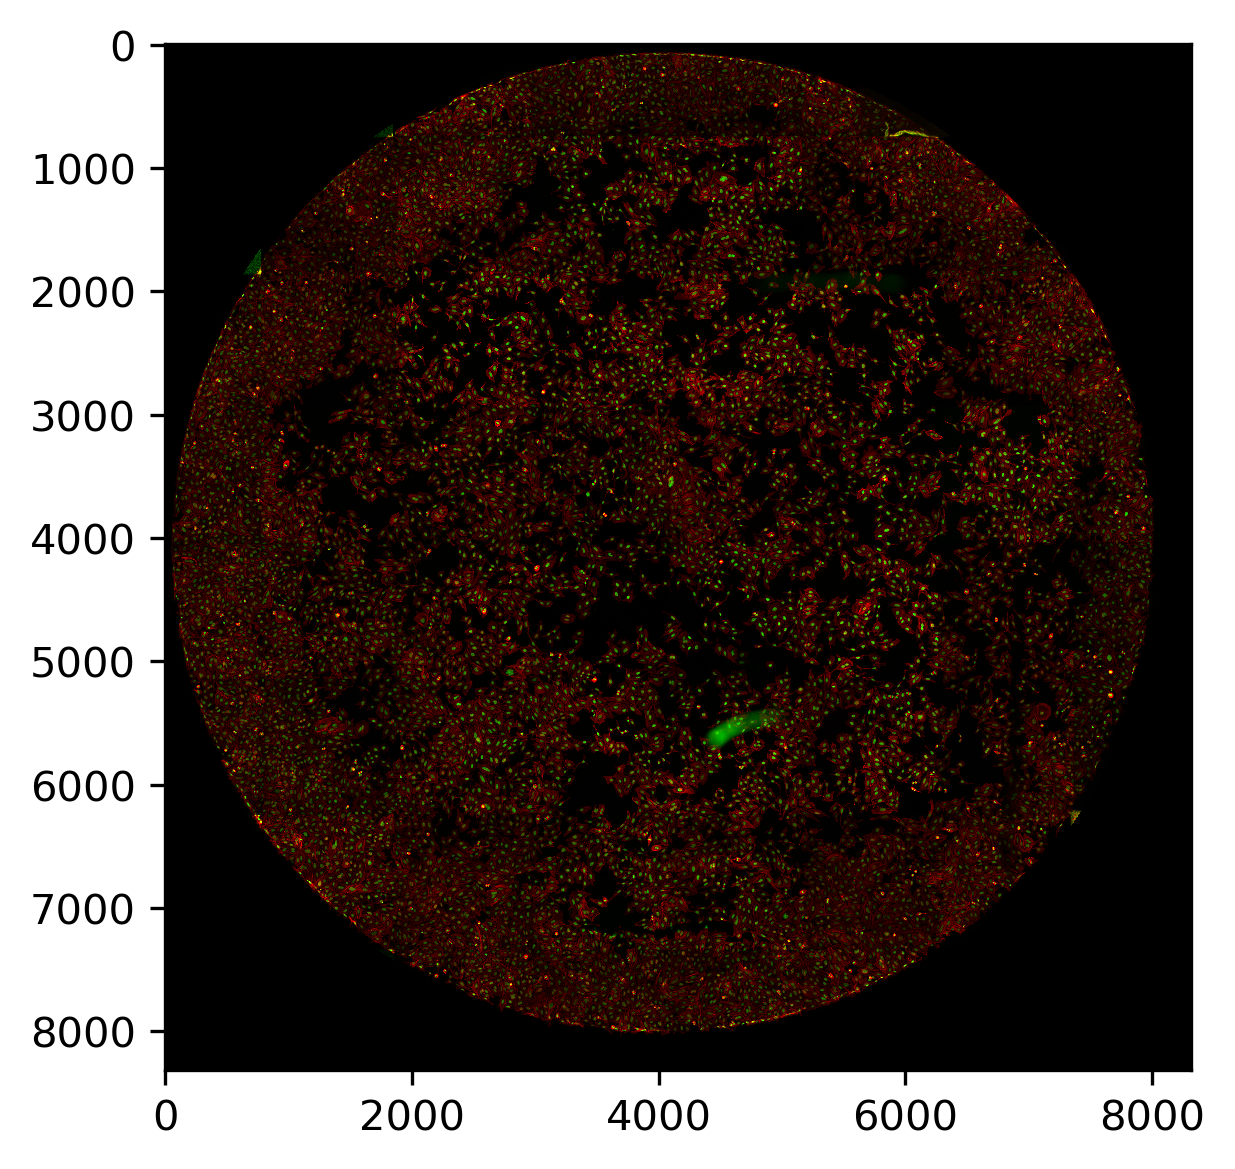

In [3]:
# experiment = 'WKS024'
# magnification = '10x'

well = 'B02'
root = '/Users/lukasvandenheuvel/Documents/DM Lab/CellContactNetwork'
[subimage_width, subimage_height] = [512,512]
overlap = 200

# READ FUSED IMAGE AND ENLARGE IT
fused_path = os.path.join(root, well+'_fused_RGB.tif')
fused = io.imread(fused_path)
[new_fused, subimage_locations] = enlarge_fused_image(fused)
io.imshow(new_fused)

In [4]:
# MAKE A LIST OF SUBIMAGES
subfig_list = fused_to_subimages(fused, subimage_locations)
print('Number of subimages to predict: %d'%len(subfig_list))

Number of subimages to predict: 676


In [5]:
# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
# ---------------------------------------------------------------------------------

model = models.Cellpose(gpu=use_GPU, model_type='cyto')

channels = [1,2] # R=cytoplasm and G=nucleus
mask_list, flows, styles, diams = model.eval(subfig_list, diameter=150, flow_threshold=None, channels=channels)

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 676 image(s)


/Users/lukasvandenheuvel/opt/anaconda3/envs/cellpose/lib/python3.7/site-packages/cellpose/transforms.py:234: UserWarning: chan to seg' has value range of ZERO
  warnings.warn("chan to seg' has value range of ZERO")
/Users/lukasvandenheuvel/opt/anaconda3/envs/cellpose/lib/python3.7/site-packages/cellpose/transforms.py:236: UserWarning: 'chan2 (opt)' has value range of ZERO, can instead set chan2 to 0
  warnings.warn("'chan2 (opt)' has value range of ZERO, can instead set chan2 to 0")
/Users/lukasvandenheuvel/opt/anaconda3/envs/cellpose/lib/python3.7/site-packages/cellpose/transforms.py:186: RuntimeWarning: divide by zero encountered in true_divide
  X = (X - np.percentile(X, 1)) / (np.percentile(X, 99) - np.percentile(X, 1))
/Users/lukasvandenheuvel/opt/anaconda3/envs/cellpose/lib/python3.7/site-packages/cellpose/transforms.py:186: RuntimeWarning: invalid value encountered in true_divide
  X = (X - np.percentile(X, 1)) / (np.percentile(X, 99) - np.percentile(X, 1))
  3%|▎         | 19/6

time spent: running network 996.91s; flow+mask computation 84.22
estimated masks for 676 image(s) in 1088.95 sec
>>>> TOTAL TIME 1088.95 sec


In [8]:
def find_edges(mask):

    padded_mask = np.pad(mask,1,mode='edge')

    center = padded_mask[1:-1,1:-1]
    up = padded_mask[0:-2,1:-1]
    up_left = padded_mask[0:-2,0:-2]
    left = padded_mask[1:-1,0:-2]

    compare = np.array((center!=up,center!=up_left,center!=left))
    edges = np.logical_or.reduce(compare)
    
    return edges

def split_cells_on_mask(mask,edges):

    compare = np.array((mask > 0, ~edges))
    segmented_mask = np.logical_and.reduce(compare)
    
    return segmented_mask

In [17]:
# Combine 4 neighbouring segmentations into 1
overlap = 200
splitted_mask_list = []
cropped_fig_list = []
start = 300
half_overlap = int(overlap/2)

for i in range(7):
    subfig = subfig_list[start+i]
    mask = mask_list[start+i]
    
    cropped_mask = mask[half_overlap:512-half_overlap, half_overlap:512-half_overlap]
    cropped_subfig = subfig[half_overlap:512-half_overlap, half_overlap:512-half_overlap,:]
    cropped_fig_list.append(cropped_subfig)
    
    splitted_mask = split_cells_on_mask(cropped_mask, find_edges(cropped_mask))
    splitted_mask_list.append(splitted_mask)

splitted = np.concatenate(splitted_mask_list)
figure = np.concatenate(cropped_fig_list)

io.imsave('splitted_mask.png',splitted)
io.imsave('figure.png',figure)

/Users/lukasvandenheuvel/opt/anaconda3/envs/cellpose/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: splitted_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


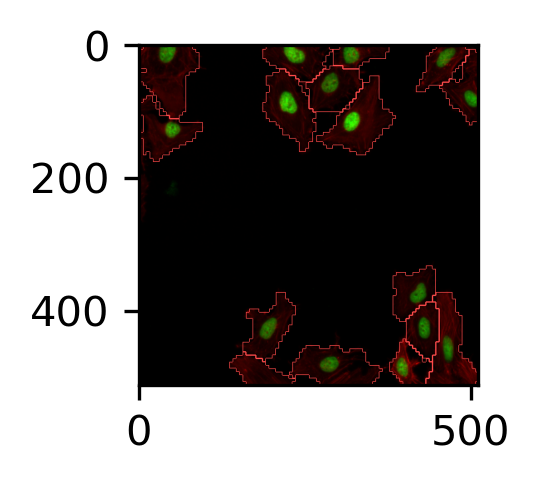

In [52]:
from cellpose import utils
mask = mask_list[300]
fig = subfig_list[300]

outlines = utils.masks_to_outlines(mask)
outX, outY = np.nonzero(outlines)
imgout = fig.copy()
imgout[outX, outY] = np.array([255,75,75])

plt.figure(figsize=(1.5,1.5))
plt.imshow(imgout)

In [42]:
from skimage.measure import find_contours
mask = splitted_mask
contours = find_contours(mask, 0.5)

In [43]:
bounding_boxes = []
for contour in contours:
    Xmin = np.min(contour[:,0])
    Xmax = np.max(contour[:,0])
    Ymin = np.min(contour[:,1])
    Ymax = np.max(contour[:,1])
    
    bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])

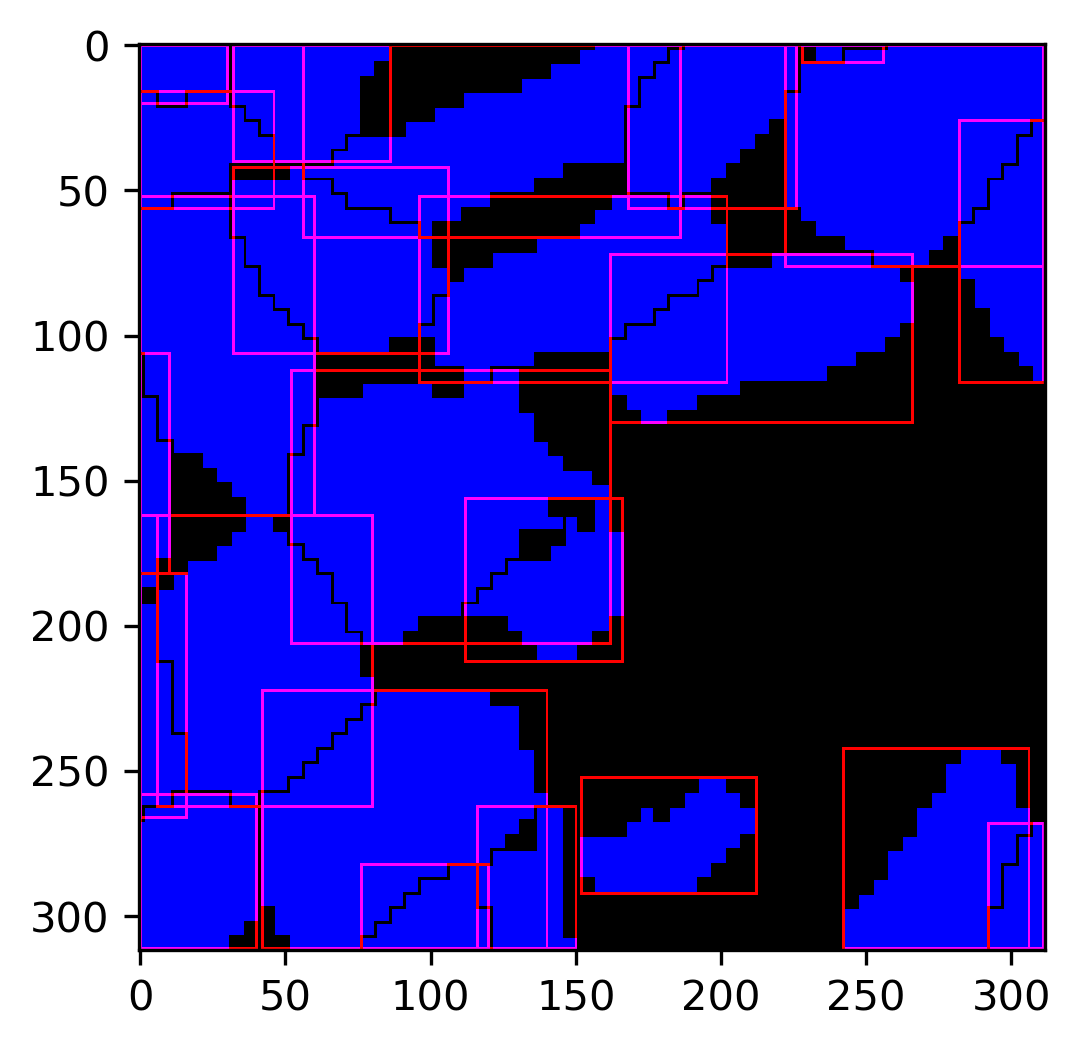

In [47]:
from skimage.draw import polygon_perimeter
N,M = np.shape(mask)
with_boxes  = np.zeros((N,M,3))
with_boxes[:,:,2] = mask

for box in bounding_boxes:
    #[Xmin, Xmax, Ymin, Ymax]
    r = [box[0],box[1],box[1],box[0], box[0]]
    c = [box[3],box[3],box[2],box[2], box[3]]
    rr, cc = polygon_perimeter(r, c, with_boxes.shape)
    with_boxes[rr, cc, 0] = 1 #set color white

plt.imshow(with_boxes, interpolation='nearest', cmap=plt.cm.gray)
plt.show()